In [1]:
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# from collections import defaultdict
# import os
# import sys
# 
# import tira.rest_api_client
# from tqdm import tqdm
# 
# tira_client = tira.rest_api_client.Client(failsave_retries=1, failsave_max_delay=1)
# task = 'generative-ai-authorship-verification-panclef-2024'
# 
# task_datasets = [d for d in tira_client.datasets(task).keys()
#                  if d != 'pan24-generative-authorship-news-check-20240523-test' and not d.endswith('-training')]
# 
# evaluations = []
# for d in tqdm(task_datasets, desc='Retrieving evaluations'):
#     e = tira_client.evaluations(task, d)
#     if e.empty:
#         continue
#     evaluations.append(e[['dataset', 'team', 'software']])
# evaluations = pd.concat(evaluations).dropna().drop_duplicates()
# 
# teams_to_softwares = defaultdict(set)
# for _, r in evaluations.iterrows():
#     teams_to_softwares[r['team']].add(str(r['software']))
# with open('teams-to-systems.json', 'w') as f: json.dump({k: sorted(v) for k, v in teams_to_softwares.items()}, f, ensure_ascii=False, indent=2)
# 
# 
# # Block verbose output
# tira.rest_api_client.tqdm = lambda *args, **_: args
# tira.rest_api_client.print = lambda *args: None
# try:
#     evaluation_scores = defaultdict(lambda: defaultdict(dict))
#     for _, r in tqdm(evaluations.iterrows(), desc='Downloading runs'):
#         dir = tira_client.download_evaluation(task, r['dataset'], r['software'], r['team'])
#         if not os.path.isfile(os.path.join(dir, 'evaluation.json')):
#             print(f'Failed to download {r["team"]}/{r["software"]}/{r["dataset"]}', file=sys.stderr)
#             continue
#         with open(os.path.join(dir, 'evaluation.json')) as f:
#             evaluation_scores[r['team']][r['software']][r['dataset']] = json.load(f)
#             
#     with open('evaluation-scores.json', 'w') as f: json.dump(evaluation_scores, f, ensure_ascii=False, indent=2)
# finally:
#     # Unscrew output muffler
#     tira.rest_api_client.tqdm = tqdm
#     del tira.rest_api_client.print

In [3]:
teams_to_systems = json.load(open('teams-to-systems.json'))
datasets = {
    # dataset_name: (category, prefix, suffix)
    'pan24-generative-authorship-test-20240502-test': ('main', '', ''),
    'pan24-generative-authorship-test-b-20240506-test': ('cross-domain', '', '-cross-domain'),
    'pan24-generative-authorship-news-test-c-20240506-test': ('unicode-full', '', '-unicode-full'),
    'pan24-generative-authorship-news-test-d-20240506-test': ('unicode-half', '', '-unicode-half'),
    # 'pan24-generative-authorship-news-test-e-20240506-test': ('german', '', '-german'),          # German was mixed into main dataset
    'pan24-generative-authorship-news-test-f-20240514-test': ('paraphrase', '', '-paraphrase'),
    'pan24-generative-authorship-news-test-g-20240529-test': ('contrastive', '', ''),              # suffix already part of the name
    'pan24-generative-authorship-news-test-h-20240521-test': ('short', '', '-short'),
    'pan24-generative-authorship-eloquent-20240523-test': ('eloquent', 'eloquent-', ''),
}

df_ = []
df_micro_mean_ = []
evaluation_scores = json.load(open('evaluation-scores.json', 'r'))
for team, systems in teams_to_systems.items():
    for s in systems:
        row_base = {'system': s, 'team': team if team != 'baseline' else s}
        for d, (dname, pre, suff) in datasets.items():
            df_micro_mean_.append({
                **row_base,
                'category': dname,
                **{k:v for k, v in evaluation_scores[team].get(s, {}).get(d, {}).items() if k != '_sources'}
            })
            df_.extend(
                {
                    **row_base,
                    'dataset': ''.join((pre, src, suff)),
                    'category': dname,
                    **evaluation_scores[team][s][d]['_sources'][src]
                } for src in evaluation_scores[team].get(s, {}).get(d, {}).get('_sources', [])
            )

df_micro_mean_ = pd.DataFrame(df_micro_mean_).fillna(0)
df_micro_mean_.set_index(['team', 'system', 'category'], inplace=True)

df_ = pd.DataFrame(df_)

team_sys_ = df_[['team', 'system']].drop_duplicates()
src_ = df_[['category', 'dataset']].drop_duplicates()
df_.set_index(['team', 'system', 'category', 'dataset'], inplace=True)

# Fill missing values for fairness
fill_ = []
for _, ts in team_sys_.iterrows():
    if ts['team'].startswith('baseline-'):
        continue
    for _, s in src_.iterrows():
        idx = (ts['team'], ts['system'], s['category'], s['dataset'])
        if idx not in df_.index:
            f = {k: v for k, v in zip(df_.index.names, idx)}
            f.update({c: 0 for c in df_.columns})
            fill_.append(f)
if fill_:
    df_ = pd.concat([df_, pd.DataFrame(fill_).set_index(df_.index.names)])

### Micro Mean (All)

In [4]:
df_micro_mean_

roc-auc  brier    c@1  \
team                system              category                              
baseline-binoculars baseline-binoculars main            0.972  0.957  0.966   
                                        cross-domain    0.970  0.955  0.962   
                                        unicode-full    0.860  0.855  0.837   
                                        unicode-half    0.298  0.462  0.320   
                                        paraphrase      0.845  0.864  0.841   
...                                                       ...    ...    ...   
ds-gtpan            nervous-blur        unicode-half    0.000  0.000  0.000   
                                        paraphrase      0.000  0.000  0.000   
                                        contrastive     0.000  0.000  0.000   
                                        short           0.494  0.482  0.482   
                                        eloquent        0.727  0.725  0.725   

                                                         f1   f05u   mean  
team                system              category                           
baseline-binoculars baseline-binoculars main          0.964  0.965  0.965  
                                        cross-domain  0.961  0.959  0.962  
                                        unicode-full  0.831  0.822  0.841  
                                        unicode-half  0.311  0.319  0.342  
                                        paraphrase    0.840  0.828  0.844  
...                                                     ...    ...    ...  
ds-gtpan            nervous-blur        unicode-half  0.000  0.000  0.000  
                                        paraphrase    0.000  0.000  0.000  
                                        contrastive   0.000  0.000  0.000  
                                        short         0.596  0.518  0.514  
                                        eloquent      0.748  0.706  0.726  

[944 rows x 6 columns]

### Macro Mean (All)

In [5]:
df_

roc-auc  \
team                system              category     dataset                                                   
baseline-binoculars baseline-binoculars main         alpaca-7b                                         0.976   
                                                     bigscience-bloomz-7b1                             0.993   
                                                     gemini-pro                                        1.000   
                                                     gemini-pro-high-temperature                       1.000   
                                                     gpt-3.5-turbo-0125                                0.984   
...                                                                                                      ...   
ds-gtpan            nervous-blur        unicode-half meta-llama-llama-2-7b-chat-hf-unicode-half        0.000   
                                        paraphrase   gemini-pro-paraphrase-paraphrase                  0.000   
                                                     gpt-4-turbo-preview-paraphrase-paraphrase         0.000   
                                        contrastive  meta-llama-llama-2-13b-chat-hf-contrastive-0.1    0.000   
                                                     meta-llama-llama-2-13b-chat-hf-contrastive-0.6    0.000   

                                                                                                     brier  \
team                system              category     dataset                                                 
baseline-binoculars baseline-binoculars main         alpaca-7b                                       0.967   
                                                     bigscience-bloomz-7b1                           0.967   
                                                     gemini-pro                                      0.983   
                                                     gemini-pro-high-temperature                     0.980   
                                                     gpt-3.5-turbo-0125                              0.963   
...                                                                                                    ...   
ds-gtpan            nervous-blur        unicode-half meta-llama-llama-2-7b-chat-hf-unicode-half      0.000   
                                        paraphrase   gemini-pro-paraphrase-paraphrase                0.000   
                                                     gpt-4-turbo-preview-paraphrase-paraphrase       0.000   
                                        contrastive  meta-llama-llama-2-13b-chat-hf-contrastive-0.1  0.000   
                                                     meta-llama-llama-2-13b-chat-hf-contrastive-0.6  0.000   

                                                                                                       c@1  \
team                system              category     dataset                                                 
baseline-binoculars baseline-binoculars main         alpaca-7b                                       0.979   
                                                     bigscience-bloomz-7b1                           0.978   
                                                     gemini-pro                                      1.000   
                                                     gemini-pro-high-temperature                     0.996   
                                                     gpt-3.5-turbo-0125                              0.974   
...                                                                                                    ...   
ds-gtpan            nervous-blur        unicode-half meta-llama-llama-2-7b-chat-hf-unicode-half      0.000   
                                        paraphrase   gemini-pro-paraphrase-paraphrase                0.000   
                                                     gpt-4-turbo-preview-paraphrase-paraphrase       0.000   
   

### Final System Selection (by Best Micro Mean Effectiveness on Main Dataset Category)

In [6]:
df_systems_final = df_micro_mean_.query('category == "main"').groupby('team')['mean'].idxmax().dropna()
df_systems_final = df_micro_mean_.loc[df_systems_final].sort_values('mean', ascending=False)
df_systems_final = df_systems_final.reset_index()[['team', 'system']]
df_systems_final.set_index(['team', 'system'], inplace=True)
df_systems_final

,
team,system
marsan,staff-trunk
iimasnlp,final-run4-gnnllm_llmft_stylofeat-partitionB
lam,blistering-moss
you-shun-you-de,charitable-mole_v3
jaha,greasy-chest
aida,corporate-burn
drocks,muffled-stock
logistic-fsu,logistic-fsu
verification-team,merciless-lease


### Dataframes Filtered

In [7]:
df = df_.loc[df_systems_final.index.get_level_values(0), df_systems_final.index.get_level_values(1), :]
df

roc-auc  \
team     system       category     dataset                                                   
marsan   staff-trunk  main         alpaca-7b                                           1.0   
                                   bigscience-bloomz-7b1                               1.0   
                                   gemini-pro                                          1.0   
                                   gemini-pro-high-temperature                         1.0   
                                   gpt-3.5-turbo-0125                                  1.0   
...                                                                                    ...   
ds-gtpan nervous-blur unicode-half meta-llama-llama-2-7b-chat-hf-unicode-half          0.0   
                      paraphrase   gemini-pro-paraphrase-paraphrase                    0.0   
                                   gpt-4-turbo-preview-paraphrase-paraphrase           0.0   
                      contrastive  meta-llama-llama-2-13b-chat-hf-contrastive-0.1      0.0   
                                   meta-llama-llama-2-13b-chat-hf-contrastive-0.6      0.0   

                                                                                   brier  \
team     system       category     dataset                                                 
marsan   staff-trunk  main         alpaca-7b                                       0.995   
                                   bigscience-bloomz-7b1                           0.993   
                                   gemini-pro                                      0.999   
                                   gemini-pro-high-temperature                     0.997   
                                   gpt-3.5-turbo-0125                              0.997   
...                                                                                  ...   
ds-gtpan nervous-blur unicode-half meta-llama-llama-2-7b-chat-hf-unicode-half      0.000   
                      paraphrase   gemini-pro-paraphrase-paraphrase                0.000   
                                   gpt-4-turbo-preview-paraphrase-paraphrase       0.000   
                      contrastive  meta-llama-llama-2-13b-chat-hf-contrastive-0.1  0.000   
                                   meta-llama-llama-2-13b-chat-hf-contrastive-0.6  0.000   

                                                                                     c@1  \
team     system       category     dataset                                                 
marsan   staff-trunk  main         alpaca-7b                                       0.995   
                                   bigscience-bloomz-7b1                           1.000   
                                   gemini-pro                                      1.000   
                                   gemini-pro-high-temperature                     0.996   
                                   gpt-3.5-turbo-0125                              1.000   
...                                                                                  ...   
ds-gtpan nervous-blur unicode-half meta-llama-llama-2-7b-chat-hf-unicode-half      0.000   
                      paraphrase   gemini-pro-paraphrase-paraphrase                0.000   
                                   gpt-4-turbo-preview-paraphrase-paraphrase       0.000   
                      contrastive  meta-llama-llama-2-13b-chat-hf-contrastive-0.1  0.000   
                                   meta-llama-llama-2-13b-chat-hf-contrastive-0.6  0.000   

                                                                                      f1  \
team     system       category     dataset                                                 
marsan   staff-trunk  main         alpaca-7b                                       0.995   
                                   bigscience-bloomz-7b1                           1.000   
                                   gemini-pro                                      1.000   
      

In [8]:
df_micro_mean = df_micro_mean_.loc[df_systems_final.index.get_level_values(0), df_systems_final.index.get_level_values(1), :]
df_micro_mean

roc-auc  brier    c@1     f1   f05u   mean
team     system       category                                                
marsan   staff-trunk  main            1.000  0.995  0.997  0.997  0.999  0.998
                      cross-domain    1.000  0.994  0.997  0.997  0.999  0.997
                      unicode-full    0.998  0.971  0.978  0.979  0.989  0.983
                      unicode-half    0.985  0.924  0.947  0.945  0.975  0.955
                      paraphrase      0.999  0.977  0.994  0.994  0.998  0.993
...                                     ...    ...    ...    ...    ...    ...
ds-gtpan nervous-blur unicode-half    0.000  0.000  0.000  0.000  0.000  0.000
                      paraphrase      0.000  0.000  0.000  0.000  0.000  0.000
                      contrastive     0.000  0.000  0.000  0.000  0.000  0.000
                      short           0.494  0.482  0.482  0.596  0.518  0.514
                      eloquent        0.727  0.725  0.725  0.748  0.706  0.726

[376 rows x 6 columns]

In [9]:
df_micro_mean_main_sorted = df_micro_mean.loc[:, :, 'main'].sort_values('mean', ascending=False)
df_micro_mean_main_sorted

,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
marsan,staff-trunk,1.000,0.995,0.997,0.997,0.999,0.998
iimasnlp,final-run4-gnnllm_llmft_stylofeat-partitionB,0.992,0.992,0.992,0.992,0.991,0.992
lam,blistering-moss,0.989,0.989,0.989,0.989,0.990,0.990
you-shun-you-de,charitable-mole_v3,0.991,0.991,0.991,0.990,0.989,0.990
jaha,greasy-chest,0.979,0.979,0.979,0.979,0.979,0.979
aida,corporate-burn,0.995,0.954,0.976,0.976,0.976,0.976
drocks,muffled-stock,0.987,0.967,0.970,0.970,0.970,0.973
logistic-fsu,logistic-fsu,0.999,0.913,0.983,0.983,0.983,0.972
verification-team,merciless-lease,0.994,0.975,0.963,0.963,0.962,0.971


### Submissions Statistics

In [10]:
global_stats = df_.reset_index()[~df_.index.get_level_values(1).str.startswith('baseline-')][['team', 'system', 'dataset']].nunique()
global_stats.name = 'unique_count'
global_stats.to_frame()

,unique_count
team,34
system,100
dataset,70


### Teams to Notebook Paper IDs

In [11]:
submission_paper_map = json.load(open('teams-to-notebook.json'))
df_team_to_notebook = []
for t, s in submission_paper_map.items():
    if t == 'baseline':
        continue
    for sn, nb in s.items():
        df_team_to_notebook.append({'team': t, 'system': sn, 'notebook': nb})
df_team_to_notebook = pd.DataFrame(df_team_to_notebook)
df_team_to_notebook.set_index(['team', 'system'], inplace=True)
df_team_to_notebook.groupby('team').max().sort_values('notebook')

,notebook
team,
petropoulossiblings,82.0
aida,83.0
karami-kheiri,85.0
no-999,86.0
turtlewu,106.0
you-na-you-de,109.0
younanyousha,110.0
you-shun-you-de,115.0
verification-team,116.0


### System Effectiveness

In [12]:
df_system_mean = df.groupby(['team', 'system']).mean().sort_values('mean', ascending=False)
print('System effectiveness (uncorrected):')
df_system_mean

System effectiveness (uncorrected):


,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
marsan,staff-trunk,0.983786,0.958200,0.954529,0.942914,0.968886,0.961743
you-shun-you-de,charitable-mole_v3,0.961186,0.956829,0.959000,0.943971,0.949029,0.954043
g-fosunlpteam,gritty-producer,0.954229,0.918914,0.948714,0.944843,0.945300,0.942300
logistic-fsu,logistic-fsu,0.970243,0.877000,0.934443,0.931214,0.928171,0.928286
baselineavengers,svm,0.960286,0.894543,0.927429,0.924614,0.921300,0.925586
lam,blistering-moss,0.911314,0.911114,0.911114,0.910757,0.910186,0.910871
fosu-stu,merciless-broth,0.945000,0.916886,0.916900,0.880943,0.889814,0.909829
drocks,muffled-stock,0.920486,0.907500,0.895686,0.890243,0.887814,0.900400
cnlp-nits-pp,direct-velocity,0.927914,0.848843,0.900857,0.879357,0.881343,0.887629


In [13]:
df_system_std = df.groupby(['team', 'system']).std().sort_values('mean')
print('System effectiveness standard deviation:')
df_system_std

System effectiveness standard deviation:


,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
gra,ash-causeway,0.000000,0.000000,0.056833,0.052673,0.056791,0.033293
you-shun-you-de,charitable-mole_v3,0.061141,0.062368,0.062683,0.077989,0.071138,0.065424
e-comm-tech,great-plan,0.084094,0.042057,0.074928,0.091401,0.094418,0.072461
marsan,staff-trunk,0.045342,0.060997,0.084438,0.118335,0.073872,0.075345
logistic-fsu,logistic-fsu,0.062265,0.053578,0.089813,0.099542,0.105067,0.079197
baselineavengers,svm,0.069774,0.052038,0.090368,0.098450,0.104612,0.079974
bayes-fsu-tfidf-vectorizer,bayes-fsu-tfidf-vectorizer,0.070211,0.061525,0.161391,0.110818,0.137875,0.102005
fosu-stu,merciless-broth,0.100152,0.070993,0.112912,0.132642,0.119567,0.104537
baseline-detectgpt-falcon,baseline-detectgpt-falcon,0.147059,0.091373,0.107957,0.109808,0.111632,0.112332


In [14]:
df_system_mean_adjusted = (df_system_mean - df_system_std).clip(0)
df_system_mean_adjusted = df_system_mean_adjusted.sort_values('mean', ascending=False)
df_system_mean_adjusted.to_csv('../data/eval-figures/system-effectiveness-adjusted.csv')
df_system_mean_adjusted.reset_index()[['team', 'mean']].to_latex(open('../data/eval-figures/system-effectiveness-adjusted.tex', 'w'), float_format='%.3f', index=False)

print('System effectiveness (corrected):')
df_system_mean_adjusted

System effectiveness (corrected):


,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
you-shun-you-de,charitable-mole_v3,0.900045,0.894461,0.896317,0.865982,0.877891,0.888618
marsan,staff-trunk,0.938444,0.897203,0.870090,0.824580,0.895014,0.886398
logistic-fsu,logistic-fsu,0.907978,0.823422,0.844630,0.831672,0.823104,0.849089
baselineavengers,svm,0.890511,0.842505,0.837061,0.826164,0.816688,0.845612
g-fosunlpteam,gritty-producer,0.823011,0.831300,0.824809,0.822383,0.822314,0.826522
fosu-stu,merciless-broth,0.844848,0.845892,0.803988,0.748301,0.770247,0.805292
lam,blistering-moss,0.790965,0.789489,0.789489,0.792769,0.786817,0.790545
drocks,muffled-stock,0.811094,0.818626,0.773243,0.759059,0.752571,0.785402
bayes-fsu-count-vectorizer,bayes-fsu-count-vectorizer,0.783071,0.786934,0.726073,0.709608,0.684323,0.741321


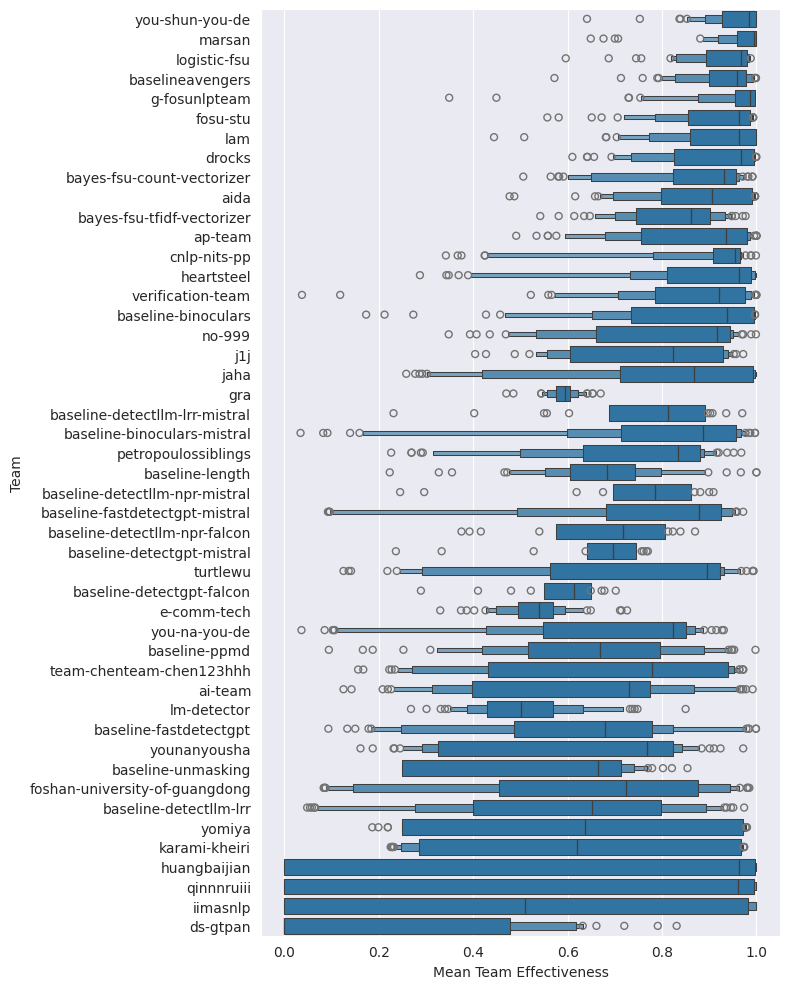

In [15]:
plt.figure(figsize=(8, 10))
sns.boxenplot(data=df, y='team', x='mean', order=df_system_mean_adjusted.reset_index()['team']).set(xlabel='Mean Team Effectiveness', ylabel='Team')
plt.tight_layout()
plt.savefig('../data/eval-figures/team-effectiveness.pdf')
plt.show()

### Dataset Difficulty

In [16]:
df_ds_mean = (1 - df).groupby('dataset').mean().sort_values('mean', ascending=False)
df_ds_mean.to_csv('../data/eval-figures/eloquent-effectiveness.csv')
df_ds_mean

,roc-auc,brier,c@1,f1,f05u,mean
dataset,,,,,,
text-bison-002-german-short,0.446214,0.387119,0.519881,0.536119,0.538786,0.485643
bigscience-bloomz-7b1-short,0.447524,0.379548,0.494833,0.542881,0.537952,0.480524
vicgalle-gpt2-open-instruct-v1-short,0.395238,0.352762,0.460643,0.583357,0.607238,0.479810
gpt-4-turbo-preview-german-short,0.446643,0.394810,0.508214,0.530762,0.514500,0.478952
alpaca-7b-short,0.378167,0.340167,0.449167,0.547286,0.581405,0.459190
...,...,...,...,...,...,...
mistralai-mistral-7b-instruct-v0.2,0.114468,0.126128,0.133340,0.134851,0.133234,0.128362
meta-llama-llama-2-70b-chat-hf,0.108830,0.121128,0.126383,0.137213,0.133872,0.125511
meta-llama-llama-2-7b-chat-hf,0.112766,0.122404,0.127830,0.129319,0.126723,0.123851


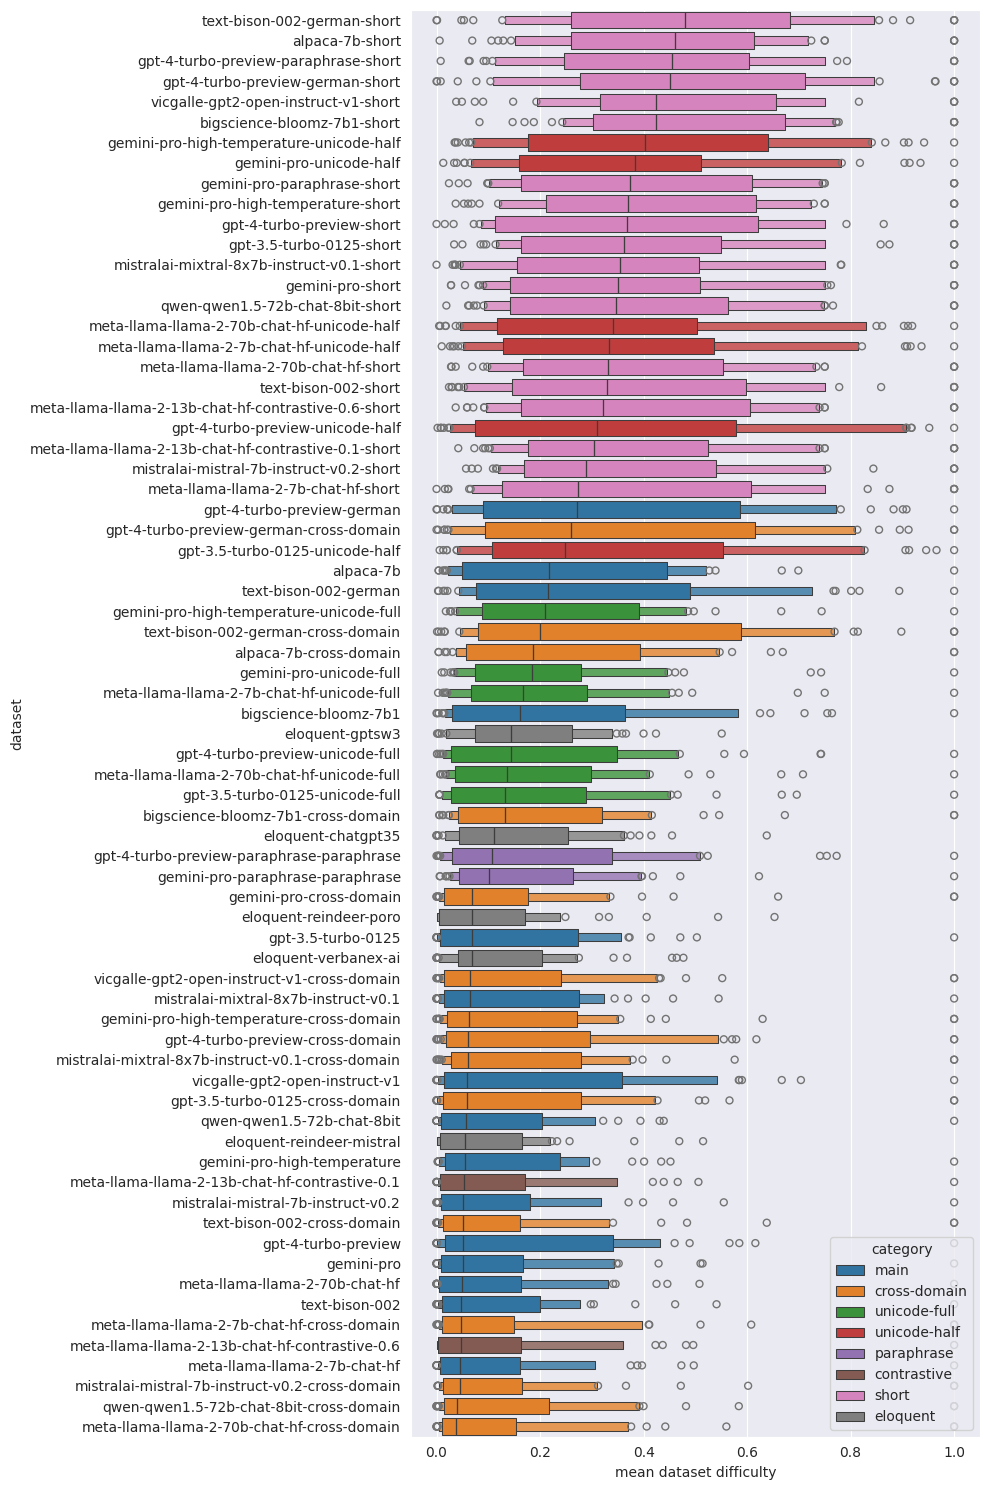

In [17]:
sort_order = df.groupby('dataset').median().sort_values('mean').index
plt.figure(figsize=(10, 15))
sns.boxenplot(data=(1 - df), y='dataset', x='mean', hue='category', order=sort_order).set(xlabel='mean dataset difficulty')
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-difficulty.pdf')
plt.show()

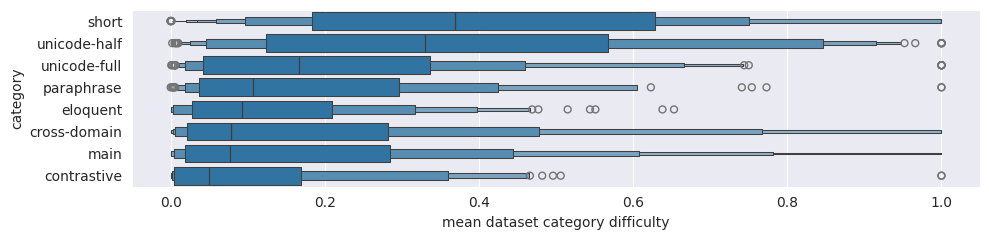

In [18]:
sort_order = df.groupby('category').median().sort_values('mean').index
plt.figure(figsize=(10, 2.5))
sns.boxenplot(data=(1 - df), y='category', x='mean', order=sort_order).set(xlabel='mean dataset category difficulty')
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-category-difficulty.pdf')
plt.show()

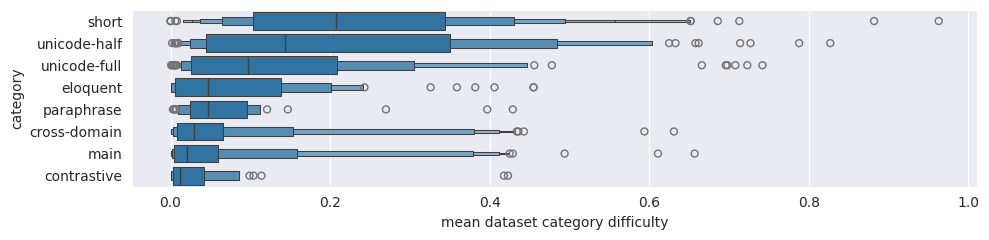

In [19]:
top_idx = df_system_mean_adjusted.iloc[:20].index
df_top = (1 - df).loc[top_idx.get_level_values(0), top_idx.get_level_values(1), :, :]
sort_order = df_top.groupby('category').mean().sort_values('mean', ascending=False).index

plt.figure(figsize=(10, 2.5))
sns.boxenplot(data=df_top, y='category', x='mean', order=sort_order).set(xlabel='mean dataset category difficulty')
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-category-difficulty-top.pdf')
plt.show()

### ELOQUENT Breaker Effectiveness

In [20]:
df_eloquent_ds = 1 - df.loc[:, :, 'eloquent']

df_eloquent = df_eloquent_ds.sort_values('mean', ascending=False)
df_eloquent.to_csv('../data/eval-figures/eloquent-effectiveness.csv')
df_eloquent

roc-auc  \
team                   system                 dataset                              
lm-detector            detector               eloquent-reindeer-poro       0.583   
baseline-detectllm-lrr baseline-detectllm-lrr eloquent-chatgpt35           0.629   
lm-detector            detector               eloquent-gptsw3              0.461   
e-comm-tech            great-plan             eloquent-reindeer-poro       0.476   
                                              eloquent-reindeer-mistral    0.465   
...                                                                          ...   
huangbaijian           bitter-metaphor        eloquent-verbanex-ai         0.000   
qinnnruiii             tender-couple          eloquent-reindeer-mistral    0.000   
                                              eloquent-reindeer-poro       0.000   
                                              eloquent-verbanex-ai         0.000   
heartsteel             canary-paint           eloquent-reindeer-mistral    0.000   

                                                                         brier  \
team                   system                 dataset                            
lm-detector            detector               eloquent-reindeer-poro     0.469   
baseline-detectllm-lrr baseline-detectllm-lrr eloquent-chatgpt35         0.356   
lm-detector            detector               eloquent-gptsw3            0.385   
e-comm-tech            great-plan             eloquent-reindeer-poro     0.323   
                                              eloquent-reindeer-mistral  0.314   
...                                                                        ...   
huangbaijian           bitter-metaphor        eloquent-verbanex-ai       0.000   
qinnnruiii             tender-couple          eloquent-reindeer-mistral  0.000   
                                              eloquent-reindeer-poro     0.000   
                                              eloquent-verbanex-ai       0.001   
heartsteel             canary-paint           eloquent-reindeer-mistral  0.000   

                                                                           c@1  \
team                   system                 dataset                            
lm-detector            detector               eloquent-reindeer-poro     0.656   
baseline-detectllm-lrr baseline-detectllm-lrr eloquent-chatgpt35         0.708   
lm-detector            detector               eloquent-gptsw3            0.542   
e-comm-tech            great-plan             eloquent-reindeer-poro     0.625   
                                              eloquent-reindeer-mistral  0.566   
...                                                                        ...   
huangbaijian           bitter-metaphor        eloquent-verbanex-ai       0.000   
qinnnruiii             tender-couple          eloquent-reindeer-mistral  0.000   
                                              eloquent-reindeer-poro     0.000   
                                              eloquent-verbanex-ai       0.000   
heartsteel             canary-paint           eloquent-reindeer-mistral  0.000   

                                                                            f1  \
team                   system                 dataset                            
lm-detector            detector               eloquent-reindeer-poro     0.789   
baseline-detectllm-lrr baseline-detectllm-lrr eloquent-chatgpt35         0.739   
lm-detector            detector               eloquent-gptsw3            0.714   
e-comm-tech            great-plan             eloquent-reindeer-poro     0.652   
                                              eloquent-reindeer-mistral  0.636   
...                                                                        ...   
huangbaijian           bitter-metaphor        eloquent-verbanex-ai       0.000   
qinnnruiii             tender-couple          eloquent-reindeer-mistral  0.000   
                          

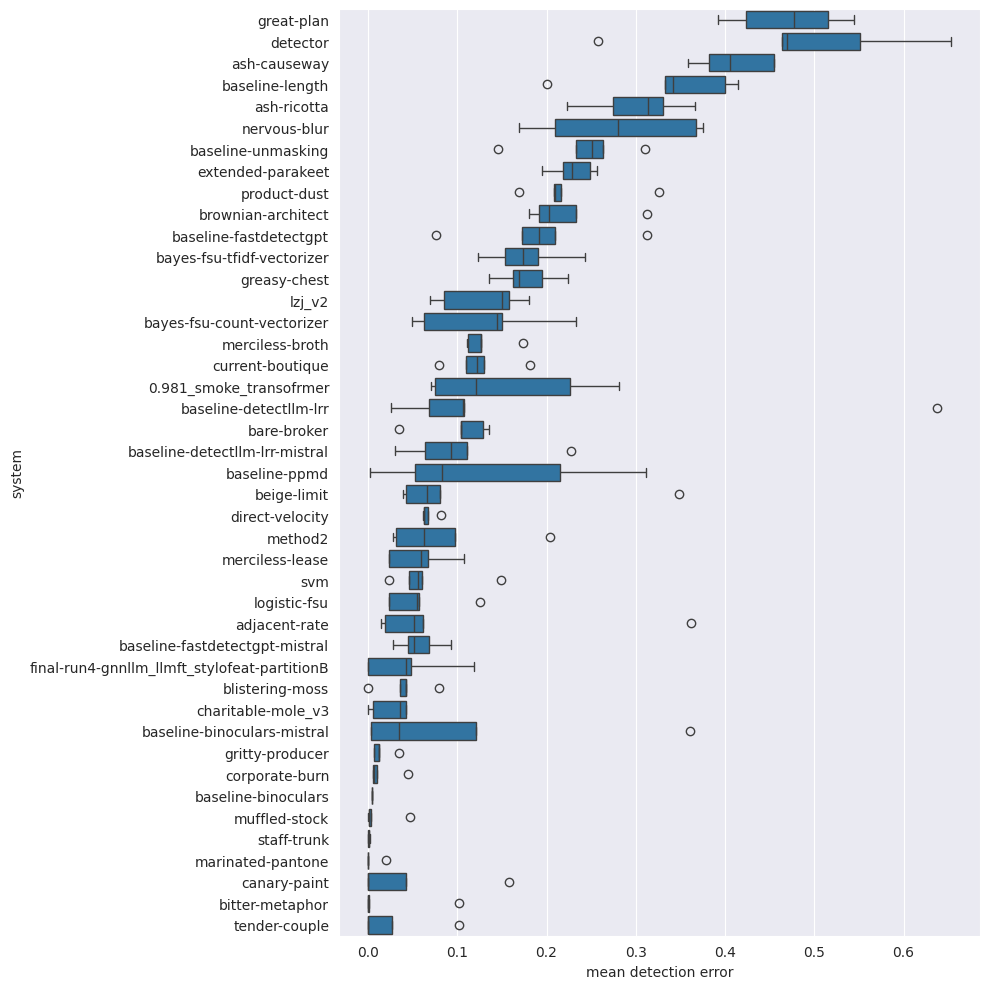

In [21]:
sort_order = df_eloquent_ds.groupby('system').median().sort_values('mean', ascending=False).index

plt.figure(figsize=(10, 10))
sns.boxplot(data=df_eloquent_ds, y='system', x='mean', order=sort_order).set(xlabel='mean detection error')
plt.tight_layout()
plt.savefig('../data/eval-figures/eloquent-system-effectiveness.pdf')
plt.show()

In [22]:
df_eloquent_mean = df_eloquent_ds.groupby('dataset').mean().sort_values('mean', ascending=False)
df_eloquent_mean.to_csv('../data/eval-figures/eloquent-effectiveness-mean.csv')
df_eloquent_mean

,roc-auc,brier,c@1,f1,f05u,mean
dataset,,,,,,
eloquent-gptsw3,0.153279,0.165581,0.181698,0.182953,0.162395,0.169186
eloquent-chatgpt35,0.135093,0.141372,0.165860,0.186000,0.197558,0.165209
eloquent-verbanex-ai,0.103953,0.125116,0.128791,0.147256,0.151140,0.131233
eloquent-reindeer-poro,0.102860,0.115512,0.119558,0.126651,0.128860,0.118721
eloquent-reindeer-mistral,0.086488,0.105860,0.104651,0.105047,0.102907,0.100977


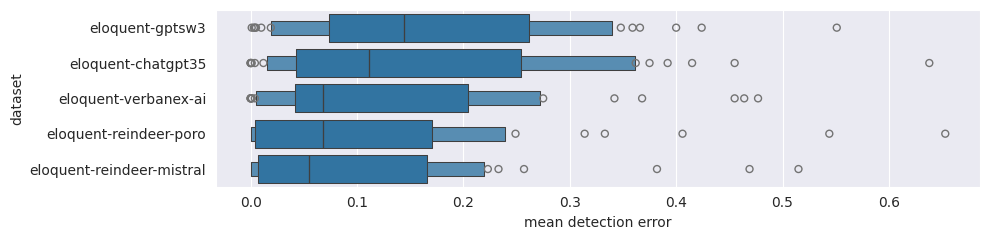

In [23]:
plt.figure(figsize=(10, 2.5))
sns.boxenplot(data=df_eloquent_ds, y='dataset', x='mean', order=df_eloquent_mean.index).set(xlabel='mean detection error')
plt.tight_layout()
plt.savefig('../data/eval-figures/eloquent-effectiveness.pdf')
plt.show()